In [1]:
import numpy as np
import pandas as pd
import sklearn.model_selection as model_selection
import tensorflow as tf
import keras
import pydot
import matplotlib.pyplot as plt

In [2]:
# Test for GPU and CUDA

print('Devices List: ', tf.config.list_physical_devices('GPU'))
print('Is built with CUDA:', tf.test.is_built_with_cuda())

Devices List:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Is built with CUDA: True


In [3]:
# List, dictionaries of class number and labels.

label_dict = {0: 'Nucleoplasm', 1: 'Nuclear membrane', 2: 'Nucleoli', 3: 'Nucleoli fibrillar center', 4: 'Nuclear speckles', 5: 'Nuclear bodies', 6: 'Endoplasmic reticulum',
         7: 'Golgi apparatus', 8: 'Peroxisomes', 9: 'Endosomes', 10: 'Lysosomes', 11: 'Intermediate filaments', 12: 'Actin filaments', 13: 'Focal adhesion sites', 
         14: 'Microtubules', 15: 'Microtubule ends', 16: 'Cytokinetic bridge', 17: 'Mitotic spindle', 18: 'Microtubule organizing center', 19: 'Centrosome', 20: 'Lipid droplets',
         21: 'Plasma membrane', 22: 'Cell junctions', 23: 'Mitochondria', 24: 'Aggresome', 25: 'Cytosol', 26: 'Cytoplasmic bodies', 27: 'Rods & rings'}

label_list = ['Nucleoplasm', 'Nuclear membrane', 'Nucleoli', 'Nucleoli fibrillar center', 'Nuclear speckles', 'Nuclear bodies', 'Endoplasmic reticulum', 
              'Golgi apparatus', 'Peroxisomes', 'Endosomes', 'Lysosomes', 'Intermediate filaments', 'Actin filaments', 'Focal adhesion sites', 
              'Microtubules', 'Microtubule ends', 'Cytokinetic bridge', 'Mitotic spindle', 'Microtubule organizing center', 'Centrosome', 'Lipid droplets', 
              'Plasma membrane', 'Cell junctions', 'Mitochondria', 'Aggresome', 'Cytosol', 'Cytoplasmic bodies', 'Rods & rings']

map_label_number = {'Nucleoplasm': 0, 'Nuclear membrane': 1, 'Nucleoli': 2, 'Nucleoli fibrillar center': 3, 'Nuclear speckles': 4, 'Nuclear bodies': 5, 'Endoplasmic reticulum': 6, 
                    'Golgi apparatus': 7, 'Peroxisomes': 8, 'Endosomes': 9, 'Lysosomes': 10, 'Intermediate filaments': 11, 'Actin filaments': 12, 'Focal adhesion sites': 13, 
                    'Microtubules': 14, 'Microtubule ends': 15, 'Cytokinetic bridge': 16, 'Mitotic spindle': 17, 'Microtubule organizing center': 18, 'Centrosome': 19, 'Lipid droplets': 20, 
                    'Plasma membrane': 21, 'Cell junctions': 22, 'Mitochondria': 23, 'Aggresome': 24, 'Cytosol': 25, 'Cytoplasmic bodies': 26, 'Rods & rings': 27}

In [4]:
# Set the path to train set

path_to_train = './train/'

In [5]:
# Global Variables

INPUT_SHAPE = (512, 512, 3) # Images all have the same dimension
BATCH_SIZE = 2 # batch size for model learing. 8 gives OOM

In [6]:
ground_truth = pd.read_csv('train.csv')
ground_truth['List Target'] = ground_truth['Target'].apply(lambda string: sorted(list(map(int, string.split(' ')))))
ground_truth['Label Target'] =  ground_truth['List Target'].apply(lambda lis: [label_list[idx] for idx in lis])
ground_truth['Label'] =  ground_truth['Label Target'].apply(lambda lis: ', '.join(lis))
ground_truth['Path'] = path_to_train + ground_truth['Id']

In [7]:
# Get train set and validation set

train, val = model_selection.train_test_split(ground_truth, test_size = 0.2, random_state = 42)

In [8]:
# OneHotEncoding

def get_clean_data(df):
    targets = []
    paths = []
    for _, row in df.iterrows():
        target_np = np.zeros(len(label_list))
        t = [int(t) for t in row.Target.split()]
        target_np[t] = 1
        targets.append(target_np)
        paths.append(row.Path)
    return np.array(paths), np.array(targets)


def load_data(path, target):
    red = tf.squeeze(tf.image.decode_png(tf.io.read_file(path + '_red.png'), channels = 1), [2])
    blue = tf.squeeze(tf.image.decode_png(tf.io.read_file(path + '_blue.png'), channels = 1), [2])
    green = tf.squeeze(tf.image.decode_png(tf.io.read_file(path + '_green.png'), channels = 1), [2])
    img = tf.stack((red, green, blue), axis=2)
    return img, target

AUTOTUNE = tf.data.experimental.AUTOTUNE

In [9]:
train_path, train_target = get_clean_data(train)
val_path, val_target = get_clean_data(val)

#print(f'Train path shape: {train_path.shape}')
#print(f'Train target shape: {train_target.shape}')
#print(f'Val path shape: {val_path.shape}')
#print(f'Val target shape: {val_target.shape}')

In [10]:
train_data = tf.data.Dataset.from_tensor_slices((train_path, train_target))
val_data = tf.data.Dataset.from_tensor_slices((val_path, val_target))

In [11]:
train_data = train_data.map(load_data, num_parallel_calls = AUTOTUNE) # prendiamo ogni elemento di train_data (che sono path) e li mappiamo nella rispettiva immagine
val_data = val_data.map(load_data, num_parallel_calls = AUTOTUNE)

In [12]:
train_data_batches = train_data.batch(BATCH_SIZE).prefetch(buffer_size = AUTOTUNE)
val_data_batches = val_data.batch(BATCH_SIZE).prefetch(buffer_size = AUTOTUNE)
train_data_batches

<PrefetchDataset shapes: ((None, None, None, 3), (None, 28)), types: (tf.uint8, tf.float64)>

In [13]:
# The model starts with a Xception layer and stack Flatten, Dropout and Dense layers.

xception_model = keras.applications.Xception(include_top = False, weights = 'imagenet') # include_top = False dovrebbe permettermi di personalizzare l'input layer
xception_model.trainable = True

input_layer = keras.layers.Input(shape = INPUT_SHAPE)
x = xception_model(input_layer)
x = keras.layers.Flatten()(x) # create a single array
x = keras.layers.Dropout(0.5)(x) # reduce overfitting
x = keras.layers.Dense(512, activation = 'relu')(x)
x = keras.layers.Dropout(0.5)(x)
output = keras.layers.Dense(28, activation = 'sigmoid')(x) # 28, one for each class
xception_model = keras.models.Model(input_layer, output)

xception_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
xception (Functional)        (None, None, None, 2048)  20861480  
_________________________________________________________________
flatten (Flatten)            (None, 524288)            0         
_________________________________________________________________
dropout (Dropout)            (None, 524288)            0         
_________________________________________________________________
dense (Dense)                (None, 512)               268435968 
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 28)                14364 

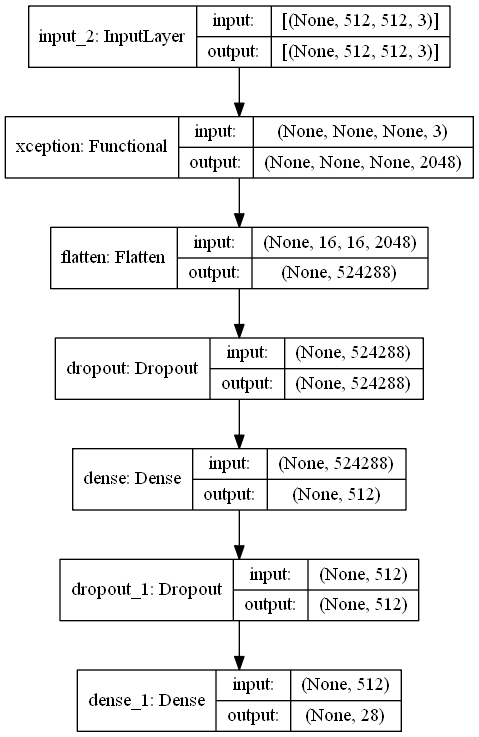

In [14]:
keras.utils.plot_model(xception_model, "xception_model.png", show_shapes = True)

In [15]:
xception_model.compile(optimizer = keras.optimizers.Adam(1e-4), loss = 'binary_crossentropy', metrics = 'binary_accuracy')

In [16]:
# Uncomment and run for training the model

history = xception_model.fit(train_data_batches, steps_per_epoch = 150, validation_data = val_data_batches, epochs = 40)

In [17]:
# Plot History

pd.DataFrame(history.history).plot(figsize=(12,4))
plt.grid(True)

In [18]:
xception_model.save('./hpa_Xception_model.tf')

INFO:tensorflow:Assets written to: ./hpa_Xception_model.tf\assets


In [19]:
###### Predict model on validation to get threshold for prediction over test set

In [20]:
def get_frequency_table(ground_truth):
    all_label = pd.DataFrame(ground_truth['Label Target'].sum(), columns = ['Label']).copy()
    frequency_table = all_label['Label'].value_counts().reset_index().copy().rename(columns = {'index': 'Label', 'Label': 'Frequency'})
    frequency_table['Numeric Label'] = pd.DataFrame(frequency_table['Label']).replace({'Label': map_label_number}).copy()
    frequency_table['Relative Frequency'] = frequency_table['Frequency'] / frequency_table['Frequency'].sum()
    frequency_table['Relative Frequency %'] = (frequency_table['Frequency'] / frequency_table['Frequency'].sum()).apply(lambda number: '{:.2%}'.format(number))
    frequency_table[['Numeric Label', 'Label', 'Frequency', 'Relative Frequency', 'Relative Frequency %']].set_index('Numeric Label')
    return frequency_table

def get_threshold_from_validation(model, val_data_batches, ground_truth, batch_size = 4, verbose = 1, steps = None):
    frequency_table = get_frequency_table(ground_truth)
    prediction = model.predict(val_data_batches, batch_size = BATCH_SIZE, verbose = verbose, steps = steps)
    freq = list(frequency_table[['Numeric Label', 'Relative Frequency']].sort_values(by='Numeric Label')['Relative Frequency'])
    thresh = np.diagonal(np.array(pd.DataFrame(prediction).quantile([1 - f for f in freq])))
    return thresh

In [21]:
# Load the model
model_Xception = keras.models.load_model('hpa_Xception_model.tf')

In [22]:
# Get threshold for prediction
thresh = get_threshold_from_validation(model_Xception, val_data_batches, ground_truth, batch_size = BATCH_SIZE, verbose = 1, steps = None)
thresh

3108/3108 [==============================] - 101s 32ms/step


array([0.51997931, 0.97072391, 0.46045949, 0.99137787, 0.72512962,
       0.95618641, 0.97886023, 0.86301403, 0.99995389, 0.99964118,
       0.99946806, 0.98000044, 0.8887235 , 0.99623207, 0.98616731,
       0.96080434, 0.99745922, 0.99978051, 0.93036813, 0.84382995,
       0.99633127, 0.99982706, 0.99987868, 0.92638686, 0.99681511,
       0.91722482, 0.67764074, 0.99690612])